<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 第7章：根据指令进行微调

In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.7.1
tiktoken version: 0.7.0
torch version: 2.4.0
tqdm version: 4.66.4
tensorflow version: 2.15.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/overview.webp" width=80%>

## 7.1 指令微调介绍


- 在第5章中，我们看到预训练LLM涉及一个训练过程，该过程学习一次生成一个单词
- 因此，预训练的LLM擅长文本补全，但不擅长遵循指令
- 在本章中，我们将教LLM更好地遵循指令


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/instruction-following.webp" width=60%>


本章所涵盖的主题在下图中进行了总结

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-1.webp?123" width=60%>

## 7.2 为监督指令微调准备数据集

- 我们将使用我为这一章准备的一个指令数据集进行工作

In [2]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- 我们从上面的JSON文件中加载的`data`列表中的每个项目都是一个以下形式的字典

In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- Note that the `'input'` field can be empty:

In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}



- 指令微调通常被称为“监督指令微调”，因为它涉及在数据集上训练模型，其中输入-输出对是明确提供的
- 将条目格式化为大型语言模型的输入有不同的方式；下面的图表展示了用于训练Alpaca的两个示例格式
(https://crfm.stanford.edu/2023/03/13/alpaca.html) 和 Phi-3 (https://arxiv.org/abs/2404.14219) LLMs, respectively

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/prompt-style.webp" width=80%>


- 在这一章中，我们使用了Alpaca风格的提示格式化，这是用于指令微调的原始提示模板。
- 下面，我们将格式化输入，作为输入传递给大型语言模型（LLM）。


In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- 带输入字段的格式化回复如下所示

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


- 以下是格式化后的回复，但没有输入字段

In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- 最后，在下一节中准备PyTorch数据加载器之前，我们将数据集分为训练集、验证集和测试集

In [8]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 将数据组织成训练批次

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-2.webp?1234" width=60%>


- 我们分几个步骤来处理这个数据集批处理，如下图所示

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/detailed-batching.webp?1" width=60%>


- 首先，我们实现了一个`InstructionDataset`类，它在数据集中对所有输入进行了预分词，类似于第6章中的`SpamDataset`

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/pretokenizing.webp" width=80%>

In [10]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


- 与第6章类似，我们希望在一个批次中收集多个训练示例以加速训练；这需要将所有输入填充到相似的长度
- 与前一章类似，我们使用`<|endoftext|>`标记作为填充标记


In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]



- 在第6章中，我们将数据集中的所有示例填充到相同的长度
  - 在这里，我们采用更复杂的方法，并开发了一个自定义的“合并”函数，可以将其传递给数据加载器
  - 这个自定义的合并函数将每个批次中的训练示例填充到相同的长度（但不同的批次可以有不同的长度）


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/padding.webp" width=80%>

In [12]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    #  torch.stack的功能解释：
    # 1)合并数据：在处理批量数据时，可以使用 torch.stack 将多个样本合并成一个批次。
    # 2) 维度扩展：当需要在模型输入中增加维度时，可以使用此方法。 
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-4.webp?1" width=80%>


- 在上面，我们仅将输入返回给大型语言模型（LLM）；然而，对于LLM的训练，我们还需要目标值。
- 与预训练LLM类似，目标是输入向右移动1个位置后的值，因此LLM学习预测下一个标记（token）。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/inputs-targets.webp" width=80%>

In [14]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [15]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])



- 接下来，我们引入一个`ignore_index`值来将所有填充令牌ID替换为一个新值；这个`ignore_index`的目的是我们可以在损失函数中忽略填充值（稍后会详细介绍）

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-5.webp?1" width=80%>

- 具体来说，这意味着我们将与`50256`相对应的标记ID替换为`-100`，如下所示

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ignore-index.webp" width=80%>

（此外，我们还引入了`allowed_max_length`，以便在需要限制样本长度时使用；如果您计划使用比GPT-2模型支持的1024个标记上下文大小更长的自己的数据集，这将非常有用）

In [16]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [17]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])



- 让我们看看用-100替换完成了什么
- 为了说明的目的，我们假设我们有一个小的分类任务，有两个类别标签，0和1，类似于第6章
- 如果我们有以下logits值（模型最后一层的输出），我们计算以下损失


In [18]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


- 现在，正如预期的那样，增加一个训练示例将影响损失

In [19]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


- 让我们看看如果我们把一个例子的类别标签替换为-100会发生什么

In [20]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- 如我们所见，这3个训练样本的结果损失与我们从2个训练样本计算得到的损失相同，这意味着交叉熵损失函数忽略了标签为-100的训练样本。
- 默认情况下，PyTorch具有cross_entropy(..., ignore_index=-100)设置，用于忽略与标签-100相对应的样本。
- 使用这个-100 ignore_index，我们可以忽略批次中用于将训练样本填充到相等长度的额外文本结束（填充）标记。
- 但是，我们不想忽略文本结束（填充）标记（50256）的第一个实例，因为它可以帮助大型语言模型（LLM）判断响应何时完成。

- 在实践中，如以下图所示，将对应指令的目标令牌ID屏蔽掉也是很常见的（这是完成本章后推荐给读者的一项练习）

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/mask-instructions.webp" width=80%>

## 7.4 为指令数据集创建数据加载器

在这一部分，我们使用`InstructionDataset`类和`custom_collate_fn`函数来实例化训练、验证和测试数据加载器

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-3.webp" width=80%>

- 之前的custom_collate_fn函数的另一个额外细节是，我们现在直接将数据移动到目标设备（例如GPU），而不是在主训练循环中执行此操作，这提高了效率，因为当我们将custom_collate_fn作为数据加载器的一部分时，它可以作为后台进程执行
- 我们使用Python的functools标准库中的partial函数，通过预先填充原始函数的device参数来创建一个新函数

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If you have a Mac with Apple Silicon chip, you can uncomment the next lines of code
# to train the model on the Mac's GPU cores. However, as of this writing, this results in
# larger numerical deviations from the results shown in this chapter, because Apple Silicon
# support in PyTorch is still experimental

# if torch.backends.mps.is_available():
#     device = torch.device("mps")

print("Device:", device)

Device: cuda


In [22]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- 接下来，我们实例化数据加载器，类似于前面的章节，但现在我们为批处理过程提供了自己的整理函数

In [23]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [24]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- 让我们看看生成的输入和目标批次的维度是什么样的

In [25]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.


- 如上所示，我们可以看到所有批次的大小均为8，但长度不同，符合预期
- 让我们也通过打印`inputs`批次中第一个训练示例的内容来双重检查输入是否包含对应于标记ID 50256的`<|endoftext|>`填充标记


In [26]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


- 同样，我们视觉上双重检查目标是否包含-100占位符标记

In [27]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


## 7.5 Loading a pretrained LLM

- 在本部分中，我们将使用与第5章5.5节和第6章6.4节中相同的代码来加载一个预训练的GPT模型。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-4.webp" width=60%>

-然而，我们并没有加载最小的1.24亿参数模型，而是加载了3.55亿参数的中等版本模型，因为1.24亿参数的模型太小，无法通过指令微调获得质量上合理的结果。

In [28]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2024-07-25 02:22:49.969483: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 02:22:50.023103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 02:22:50.023136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 02:22:50.024611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 02:22:50.033304: I tensorflow/core/platform/cpu_feature_guar

- 在我们开始对下一节中的模型进行微调之前，让我们看看它在其中一个验证任务上的表现如何

In [29]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [30]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)


- 注意，我们在前几章中使用的 `generate` 函数返回的是输入和输出文本的合并结果，这在前面的部分中对于创建清晰的文本来说很方便。
- 为了分离出响应，我们可以从 `generated_text` 的开始处减去指令的长度。


In [31]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


- 如我们所见，该模型目前还不能按照指令操作；它创建了一个“回复”部分，但只是简单地重复了原始输入句子以及指令

## 7.6 Finetuning the LLM on instruction data


在本节中，我们对模型进行微调

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-5.webp" width=80%>

- 注意，我们可以重用我们在前几章中使用的所有损失计算和训练函数

In [32]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

-在我们开始训练之前，我们先计算初始训练和验证集的损失（和之前的章节一样，目标是最小化损失）

In [33]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.82590970993042
Validation loss: 3.761933755874634


- 请注意，由于我们使用的是较大的模型（3.55亿参数而不是1.24亿参数），因此训练成本略高于前几章。
- 下面给出了各种设备的运行时间作为参考（在兼容的GPU设备上运行此笔记本不需要对代码进行任何更改）

<div style="text-align: left;">
    
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>

- 我使用 `"gpt2-medium (355M)"` 模型运行了这个笔记本

In [34]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.728
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss


- 根据上面的输出，我们可以看到模型训练得很好，因为训练损失和验证损失值都在减少
- 此外，根据每个epoch后打印的响应文本，我们可以看到模型正确地遵循了指令，将输入句子“'The chef cooks the meal every day.'”转换为被动语态“'The meal is cooked every day by the chef.'”（我们将在后面的部分中正确格式化和评估响应）
- 最后，让我们看看训练和验证损失曲线

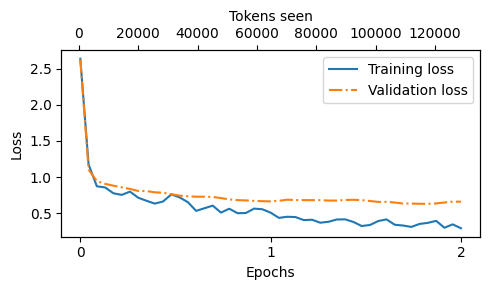

In [35]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 如我们所见，在第一个周期的开始，损失急剧下降，这意味着模型开始迅速学习
- 我们可以看到，在大约1个训练周期时，出现了轻微的过拟合现象

## 7.7 提取和保存响应

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-6.webp" width=80%>

- 在这一节中，我们保存测试集响应以便在下一节中评分
- 我们还保存一份模型副本以备将来使用
- 但首先，让我们简要查看一下微调模型生成的响应

In [36]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej


- 根据测试集说明、给定响应和模型的响应，我们可以看出该模型表现相对较好
- 第一个和最后一个说明的答案显然是正确的
- 第二个答案很接近；模型回答的是“积云”而不是“积雨云”（但请注意，积云可以发展成积雨云，积雨云能够产生雷暴）
- 最重要的是，我们可以看到，模型评估并不像前一章那样直接，在那里我们只需要计算正确的垃圾邮件/非垃圾邮件类别标签的百分比来获得分类准确率
- 在实践中，像聊天机器人这样的指令微调大型语言模型（LLMs）通过多种方法进行评估
  MMLU等短答案和多项选择基准测试 ("Measuring Massive Multitask Language Understanding", [https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)),测试模型知识的测试
  - 与其他大型语言模型（如LMSYS聊天机器人竞技场）相比的人类偏好比较 ([https://arena.lmsys.org](https://arena.lmsys.org))
  - 自动对话基准测试，其中使用另一个像GPT-4这样的LLM来评估响应，例如AlpacaEval ([https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/))
- 在下一部分，我们将使用类似于AlpacaEval的方法，并使用另一个大型语言模型（LLM）来评估我们模型的响应；但是，我们将使用我们自己的测试集，而不是使用公开可用的基准数据集
- 为此，我们将模型响应添加到test_data字典中，并将其保存为"instruction-data-with-response.json"文件以进行记录，以便在需要时我们可以在单独的Python会话中加载和分析它

In [37]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [01:11<00:00,  1.54it/s]


- 让我们再次检查其中一个条目，看看响应是否已正确添加到`test_data`字典中

In [38]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


- 最后，我们也保存了模型，以便将来需要时重复使用

In [39]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## 7.8 评估微调后的大型语言模型（LLM）

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-7.webp" width=80%>

- 在本节中，我们使用另一个更大的LLM自动评估微调后的LLM的响应
- 特别是，我们使用Meta AI的经过指令微调的80亿参数的Llama 3模型，该模型可以通过ollama在本地运行 ([https://ollama.com](https://ollama.com))
-（或者，如果您更喜欢通过OpenAI API使用功能更强大的LLM，如GPT-4，请参见） [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb) notebook)

- Ollama是一个用于高效运行LLM（大型语言模型）的应用程序
- 它是llama.cpp的一个包装器 ([https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)),它使用纯C/C++实现大型语言模型（LLMs），以最大化效率。请注意，这是一个使用LLMs生成文本（推理）的工具，而不是用于训练或微调LLMs的工具。
- 在运行以下代码之前，请通过访问以下链接安装ollama： [https://ollama.com](https://ollama.com) 并按照说明操作（例如，点击“下载”按钮并为您的操作系统下载ollama应用程序）

- 对于 macOS 和 Windows 用户，点击您下载的 ollama 应用程序；如果它提示您安装命令行用法，请说“是”
- Linux 用户可以使用 ollama 网站上提供的安装命令
- 通常，在我们可以从命令行使用 ollama 之前，我们必须启动 ollama 应用程序或在单独的终端中运行 ollama serve

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ollama-run.webp" width=80%>


- 在另一个终端中运行ollama应用程序或ollama serve，然后在命令行中执行以下命令来尝试使用具有80亿参数的Llama 3模型（该模型占用4.7 GB的存储空间，首次执行此命令时会自动下载）

```bash
# 8B model
ollama run llama3
```


- 输出如下所示

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```


- 注意，“llama3”指的是经过微调、具有80亿参数的Llama 3模型。

- 使用ollama与“llama3”模型（即80亿参数的模型）需要16GB的RAM；如果你的机器不支持，你可以尝试较小的模型，比如通过将`model = "phi-3"`设置为38亿参数的phi-3模型，这只需要8GB的RAM。

- 或者，如果你的机器支持，你也可以使用更大的700亿参数的Llama 3模型，只需将“llama3”替换为“llama3:70b”即可。

- 下载完成后，你将看到一个命令行提示符，允许你与模型进行聊天。

- 尝试一个像“羊驼吃什么？”这样的提示，它应该返回一个类似以下的输出。


```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```

- 您可以使用输入/bye来结束本次会话

- 以下代码在继续使用ollama评估我们在上一节中生成的测试集响应之前，会检查ollama会话是否正在正确运行

In [1]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [2]:
# This cell is optional; it allows you to restart the notebook
# and only run section 7.7 without rerunning any of the previous code
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- 现在，与之前我们用来与模型交互的`ollama run`命令不同，另一种方式是通过Python中的REST API使用以下函数进行交互
- 在您运行此笔记本中的下一个单元格之前，请确保ollama仍在运行（之前的代码单元格应打印出`"Ollama running: True"`）
- 接下来，运行以下代码单元格以查询模型

In [3]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

- 现在，使用我们上面定义的`query_model`函数，我们可以评估我们的微调模型的响应；让我们在之前部分中查看的前3个测试集响应上尝试一下

In [4]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might find the comparison slightly less vivid or evocative than others. For example, comparing something to lightning (as in the original response) can be more dramatic and attention-grabbing. However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea of the car's speed.

Overall, I think the model did a great job!

-------------------------

Dataset response:
>> The type of cloud typically a

- 如我们所见，Llama 3模型提供了一个合理的评估，并且如果模型不完全正确，它也会给出部分分数，这可以从“积云”答案中看出
- 请注意，之前的提示返回了非常详细的评估；我们可以调整提示以生成0到100之间的整数响应（其中100为最佳），以计算我们模型的平均分数
- 在M3 MacBook Air笔记本电脑上，测试集中110个条目的评估大约需要1分钟

In [5]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|████████████████████████| 110/110 [01:10<00:00,  1.57it/s]

Number of scores: 110 of 110
Average score: 50.32



- 我们的模型平均得分超过50分，我们可以将其作为参考点，将模型与其他模型进行比较，或者尝试其他可能改进模型的训练设置
- 请注意，ollama在跨操作系统时（截至本文撰写时）并非完全确定性的，因此您获得的数字可能与上面显示的数字略有不同


供参考：

- 原始Llama 3 8B基础模型得分为58.51
- Llama 3 8B指令模型得分为82.65


## 7.9 结论

### 7.9.1 下一步是什么
- 这标志着本书的最后一章
- 我们涵盖了大型语言模型（LLM）开发周期的主要步骤：实现LLM架构、对LLM进行预训练，以及对其进行微调

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/final-overview.webp" width=80%>


- 正如本章所述，在指令微调之后有时会进行偏好微调，这是一个可选步骤
- 偏好微调过程对于将模型定制为更好地与特定用户偏好保持一致特别有用；如果您对此感兴趣，请查看[../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo)文件夹


- 这个GitHub仓库还包含了大量你可能喜欢的附加奖励材料；更多信息，请参见 [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) 这个存储库的README页面上的部分

### 7.9.2 在快速变化的领域保持最新状态

- 本部分无代码

### 7.9.3 最后的话

- 我希望你喜欢这个从零开始实现大型语言模型（LLM）并编写预训练和微调功能的旅程
- 在我看来，从零开始实现一个大型语言模型（LLM）是理解LLM工作原理的最佳方式；我希望你通过这种方法获得了更好的理解
- 虽然这本书主要用于教学目的，但你可能对在现实世界的应用中使用不同且更强大的LLM感兴趣
- 对此，您可以考虑使用诸如axolotl之类的流行工具 ([https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)) or LitGPT ([https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt)),我帮助开发的


## 摘要和要点

- 请查看[./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py)脚本，这是一个用于分类微调的自包含脚本
- [./ollama_evaluate.py](./ollama_evaluate.py)是一个基于第7.8节的独立脚本，它使用Ollama和Llama 3评估包含“output”和“response”键的JSON文件
- [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb)笔记本说明了如何在新会话中加载微调后的模型
- 您可以在[./exercise-solutions.ipynb](./exercise-solutions.ipynb)中找到练习解决方案
